In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

In [2]:
num_det = 13

In [3]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def He_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="He 0. 0. 0.0;",
        basis=f"ccecpccpvqz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, num_det,2)
    # mc.fcisolver.nroots = 2
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [4]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = He_casci(scf_checkfile, ci_checkfile)


dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [5]:
import pyqmc.api as pyq
from wftools import generate_slater

In [6]:
# Boson WF
import importlib, bosonwftools, bosonslater
modules = [bosonwftools, bosonslater] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)


import bosonwftools, jastrowspin, bosonslater
import pyscftools, mc
wf0, _ = bosonwftools.generate_boson_wf(mol, mf, mc=mcc)
wave_functions = wf0.wf_factors
for wave in wave_functions:
    if isinstance(wave, bosonslater.BosonWF):
        boson_wf = wave
    if isinstance(wave, jastrowspin.JastrowSpin):
        jastrow_wf = wave       
                


In [7]:
configs = pyq.initial_guess(mol, 7)
configs.configs

array([[[-0.94312677,  0.84598022, -0.70711511],
        [ 0.28624575, -0.38784742, -0.69657242]],

       [[-0.16908978,  0.02460599, -1.56959661],
        [ 0.28097995, -0.3545951 , -0.17889664]],

       [[ 0.29106732, -0.08756892,  0.51522506],
        [ 0.44690148,  0.70024912,  0.05895729]],

       [[ 1.59830161,  1.76713091,  1.03388289],
        [-0.87251101, -1.26700149, -0.06897387]],

       [[-1.39691724, -1.33403602,  0.7307372 ],
        [ 0.08102924,  1.35066611, -3.65890205]],

       [[ 0.34590151, -1.18600133,  0.14469353],
        [-0.06249577, -0.29824115, -0.55883621]],

       [[-1.73507658,  0.37444909, -1.58555444],
        [ 0.12272594,  1.2158283 ,  0.08075758]]])

In [8]:
import bosonslater
modules = [bosonwftools, bosonslater] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Boson grad
e = 0
boson_wf.recompute(configs)
g = boson_wf.gradient(e, configs.electron(e))
gradb = mc.limdrift(np.real(g.T))
valueb = boson_wf.value()
print(gradb)
_,_,phases = boson_wf.value_all()
phases

[[ 0.65806438 -0.57723322  0.48348018]
 [ 0.11984337 -0.01789627  0.9926315 ]
 [-0.87313677  0.14775227 -0.05609982]
 [-0.62659493 -0.67029357 -0.39759945]
 [ 0.69967325  0.6281919  -0.34034141]
 [-0.27822337  0.95344347 -0.11634989]
 [ 0.74730474 -0.15937099  0.64508644]]


array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1., -1.,  1.],
       [-1., -1.,  1., ..., -1., -1.,  1.],
       ...,
       [-1.,  1., -1., ..., -1.,  1.,  1.],
       [-1., -1.,  1., ..., -1., -1.,  1.],
       [-1.,  1., -1., ..., -1., -1., -1.]])

In [9]:
from wftools import generate_slater
wfs = []
num_det = mcc.ci.shape[0] * mcc.ci.shape[1]
for i in range(mcc.ci.shape[0]):
    for j in range(mcc.ci.shape[1]):
        mc0 = copy.copy(mcc)
        mc0.ci = mcc.ci * 0
        mc0.ci[i, j] = 1
        wf0, _ = generate_slater(mol, mf, mc=mc0, optimize_determinants=False)
        wfs.append(wf0)

# Fermion grad
e = 0
_ = [wf.recompute(configs) for wf in wfs]
grads = [np.real(wf.gradient(e, configs.electron(e)).T) for wf in wfs]
vals = [np.real(wf.value()) for wf in wfs]
grad = mc.limdrift(np.mean(grads, axis=0))
grad

array([[-0.35722195, -0.85841081, -0.36813499],
       [-0.32788235,  0.89515001,  0.30199275],
       [ 0.25897281, -0.95194611,  0.16349828],
       [-0.55194747, -0.64762533, -0.52529556],
       [ 0.59575383,  0.5813654 , -0.55415851],
       [-0.07657151,  0.10188888, -0.99184447],
       [ 0.82684769, -0.05175617,  0.56003946]])

In [10]:
# Boson WF
import importlib, bosonwftools, bosonslater_old
modules = [bosonwftools, bosonslater_old] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)


boson_wf2 = bosonslater_old.BosonWF(mol, mf, mc=mcc)

import bosonslater_old
modules = [bosonwftools, bosonslater_old] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Boson grad
e = 0
boson_wf2.recompute(configs)
g = boson_wf2.gradient(e, configs.electron(e))
gradb = mc.limdrift(np.real(g.T))
valueb = boson_wf2.value()
print(gradb)


[[ 0.65806438 -0.57723322  0.48348018]
 [ 0.11984337 -0.01789627  0.9926315 ]
 [-0.87313677  0.14775227 -0.05609982]
 [-0.62659493 -0.67029357 -0.39759945]
 [ 0.69967325  0.6281919  -0.34034141]
 [-0.27822337  0.95344347 -0.11634989]
 [ 0.74730474 -0.15937099  0.64508644]]


In [11]:
import gpu
value, real_values, _ = boson_wf.value_all()
grads = []
ratios = []
tstep = 0.5
nconf = 7
gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
for wf in boson_wf.wfs: # over n 
    nc = copy.deepcopy(configs)
    nc.configs[:, e, :]+=gauss
    wf_grad, wf_ratio, _ = wf.gradient_value(e, nc.electron(e))
    grads.append(wf_grad)
    ratios.append(wf_ratio)
grads = gpu.asnumpy(np.array(grads))    
ratios = gpu.asnumpy(np.array(ratios))

In [39]:
ratios.shape

(4, 7, 13)

In [13]:
ratios.shape

(169, 7)

In [14]:
nc.configs[:, e, :].shape

(7, 3)

In [35]:
s = int(e >= wf._nelec[0])
nc = copy.deepcopy(configs)
aograd = wf.orbitals.aos("GTOval_sph_deriv1", nc.electron(e))
mograd = wf.orbitals.mos(aograd, s)
mograd_vals = mograd[:, :, wf._det_occup[s]]
# print(aograd.shape, mograd_vals.shape, wf._inverse[s][..., e - s * wf._nelec[0]].shape)

ratios = gpu.cp.einsum(
            "ei...dj,idj...->ei...d",
            mograd_vals,
            wf._inverse[s][..., e - s * wf._nelec[0]],
        )
# ratios = gpu.asnumpy(wf._testrowderiv(e, mograd_vals))
# ratios[0].shape
# # ratios.shape

In [36]:
det_array = (
    wf._dets[0][0, :, wf._det_map[0]]
    * wf._dets[1][0, :, wf._det_map[1]]
    * np.exp(
        wf._dets[0][1, :, wf._det_map[0]]
        + wf._dets[1][1, :, wf._det_map[1]]
    )
)
det_array.shape

(169, 7)

In [37]:
real_values


array([[9.74222684e-04, 2.26681184e-03, 1.64691504e-02, ...,
        1.58061725e-08, 3.80696687e-03, 1.72227332e-05],
       [1.66189538e-04, 6.32566752e-04, 2.92409736e-03, ...,
        3.84547089e-07, 9.41130981e-04, 1.19736654e-08],
       [9.58157049e-04, 9.54680457e-05, 5.97241032e-04, ...,
        4.12037151e-10, 1.43501209e-03, 3.28889545e-06],
       ...,
       [1.30232884e-04, 8.93023780e-06, 4.75355608e-03, ...,
        5.24792734e-18, 1.09232527e-07, 1.29827233e-05],
       [1.56065509e-03, 6.22834689e-03, 6.52358036e-02, ...,
        1.69206823e-10, 7.42511869e-05, 3.71286049e-07],
       [2.97155287e-04, 2.51897576e-05, 5.68523492e-02, ...,
        1.03964876e-09, 7.99804674e-06, 2.27960081e-07]])

In [38]:
rr=ratios[..., wf._det_map[s]]
rr.shape

(4, 7, 169)

In [41]:

def plot_delta_ovlp(filename="abvmc.hdf5", discard = 2, annot=True):
    f = h5py.File(filename, "r")    
    keys = f.keys()
    
    fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    ovlp_ij_raw=np.array(f['excitationsovlp_ij'])
    delta_ij_raw=np.array(f['excitationsdelta'])
    discard = 2
    ovlp_ij = np.average(ovlp_ij_raw[discard:], axis=0)
    # plt.figure()
    sns.heatmap(ovlp_ij, ax=ax[0, 0], annot=annot)
    ax[0, 0].set_title('Overlap matrix')
    # plt.title('Overlap matrix')

    ovlp_ij_std = np.std(ovlp_ij_raw[discard:], axis=0)
    sns.heatmap(ovlp_ij_std, ax=ax[1, 0], annot=annot)
    ax[1, 0].set_title('Standard deviation of overlap matrix')
    
    filtered_ovlp_ij = copy.deepcopy(ovlp_ij)
    filtered_ovlp_ij[ovlp_ij_std>np.abs(ovlp_ij)] = 0
    sns.heatmap(filtered_ovlp_ij, ax=ax[2, 0], annot=annot)
    ax[2, 0].set_title('Filtered overlap matrix')
    


    delta_ij = np.average(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij, ax=ax[0, 1], annot=annot)
    ax[0, 1].set_title('Delta matrix')
                       
    delta_ij_std = np.std(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij_std, ax=ax[1, 1], annot=annot)
    ax[1, 1].set_title('Standard deviation of delta matrix')
    

    filtered_delta_ij = copy.deepcopy(delta_ij)
    filtered_delta_ij[delta_ij_std>np.abs(delta_ij)] = 0
    sns.heatmap(filtered_delta_ij, ax=ax[2, 1], annot=annot)
    ax[2, 1].set_title('Filtered Delta matrix')
    
    return {'filtered': [filtered_ovlp_ij, filtered_delta_ij], 
            'raw': [ovlp_ij_raw, delta_ij_raw]}
# res = plot_delta_ovlp()

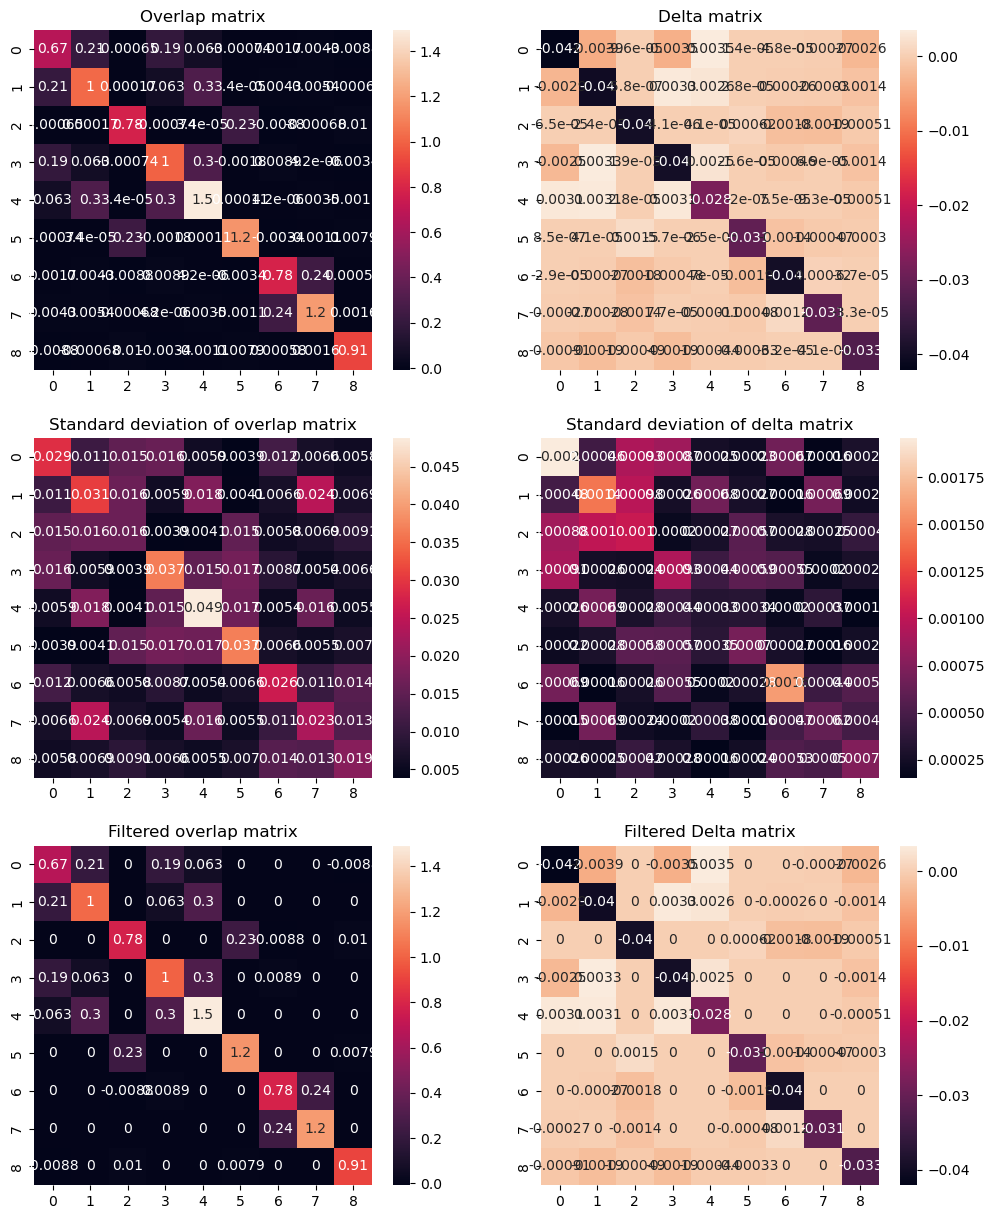

In [47]:
res = plot_delta_ovlp("abvmc-he-4.hdf5", discard=10, annot=True)

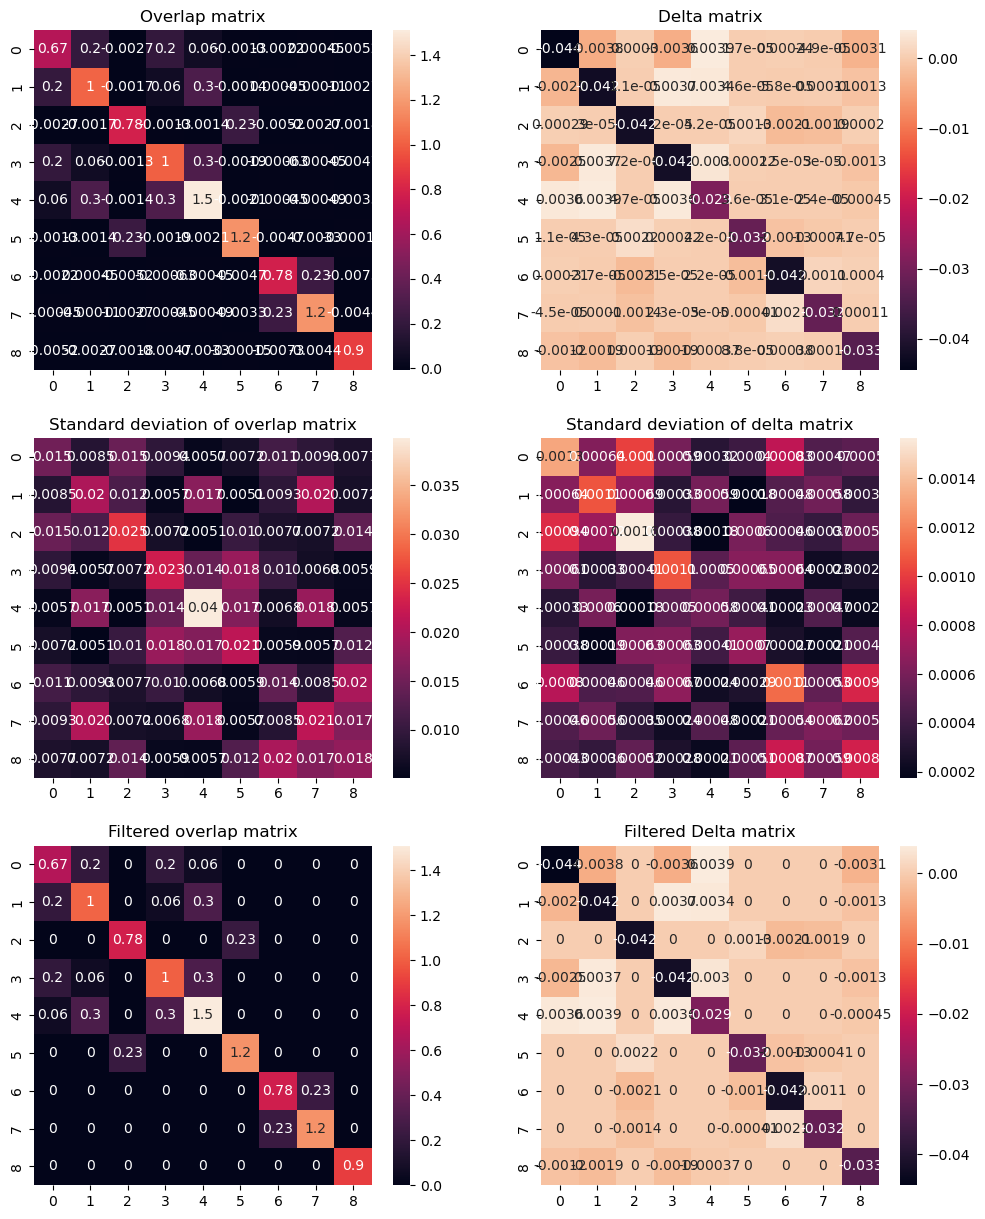

In [46]:
res = plot_delta_ovlp("abvmc-he-4.hdf5", discard=10, annot=True)